<a href="https://colab.research.google.com/github/anjum166/anjum166/blob/main/Potato_Disease_Prediction(SVM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving PlantVillage.zip to PlantVillage.zip


In [ ]:
import zipfile
import os

# Path to your uploaded ZIP file
zip_path = "/content/PlantVillage.zip"  # Replace with your actual zip filename

# Path to extract the contents
extract_path = "/content/dataset"

# Create the directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset unzipped successfully at:", extract_path)


✅ Dataset unzipped successfully at: /content/dataset


In [ ]:
os.listdir(extract_path)

['PlantVillage']

In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import joblib
import matplotlib.pyplot as plt

In [ ]:
dataset_path=r"/content/dataset/PlantVillage"

In [ ]:
# HOG + Labels
features = []
labels = []

In [ ]:
# Loop through all images
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        print("Processing:", folder)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (128, 128))
                    hog_feat = hog(img, orientations=9, pixels_per_cell=(8, 8),
                                   cells_per_block=(2, 2), block_norm='L2-Hys')
                    features.append(hog_feat)
                    labels.append(folder)
            except Exception as e:
                print("Error:", e)

Processing: Potato___healthy
Processing: Potato___Early_blight
Processing: Potato___Late_blight


In [ ]:
# Convert to arrays
X = np.array(features)
le = LabelEncoder()
y = le.fit_transform(labels)
print("Total samples processed:", len(X))
print("Classes:", le.classes_)

Total samples processed: 2152
Classes: ['Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy']


In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Train SVM model
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [ ]:
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("SVM Accuracy:", accuracy)
print(classification_report(y_test, y_pred, target_names=le.classes_))

SVM Accuracy: 0.7819025522041764
                       precision    recall  f1-score   support

Potato___Early_blight       0.83      0.79      0.81       194
 Potato___Late_blight       0.78      0.83      0.80       209
     Potato___healthy       0.43      0.36      0.39        28

             accuracy                           0.78       431
            macro avg       0.68      0.66      0.67       431
         weighted avg       0.78      0.78      0.78       431



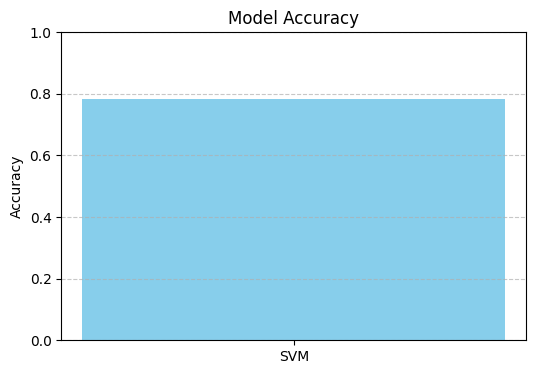

In [ ]:
# Plot accuracy
plt.figure(figsize=(6, 4))
plt.bar(['SVM'], [accuracy], color='skyblue')
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Save model and label encoder
joblib.dump(svm, "potato_svm_model.pkl")
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [ ]:
# Load and use for prediction
def predict_disease(img_path):
    try:
        model = joblib.load("potato_svm_model.pkl")
        label_encoder = joblib.load("label_encoder.pkl")

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print("Error: Could not read image.")
            return

        # Show the image
        img_display = cv2.imread(img_path)
        img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
        plt.imshow(img_display)
        plt.title("Input Image")
        plt.axis("off")
        plt.show()

        img = cv2.resize(img, (128, 128))
        hog_feat = hog(img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys')
        hog_feat = hog_feat.reshape(1, -1)

        prediction = model.predict(hog_feat)
        predicted_label = label_encoder.inverse_transform(prediction)
        print("Predicted Disease:", predicted_label[0])

    except Exception as e:
        print("Prediction Error:", e)


Running prediction for example image:


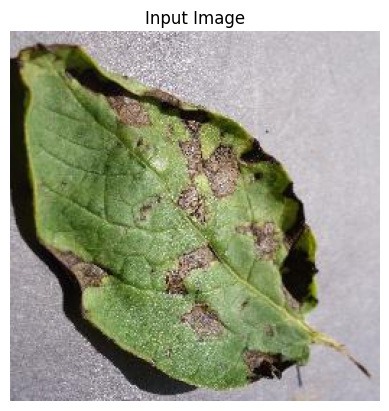

Predicted Disease: Potato___Early_blight


In [ ]:
# Example usage with image display
image_path = r"/content/dataset/PlantVillage/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG"
print("Running prediction for example image:")
predict_disease(image_path)

Running prediction for example image:


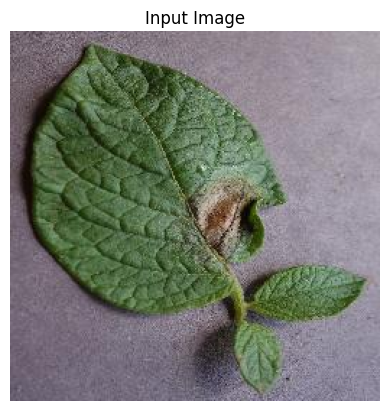

Predicted Disease: Potato___Late_blight


In [ ]:
# Example usage with image display
image_path = r"/content/dataset/PlantVillage/Potato___Late_blight/0085ef03-aec3-431a-99a1-de286e10c0cf___RS_LB 2949.JPG"
print("Running prediction for example image:")
predict_disease(image_path)

Running prediction for example image:


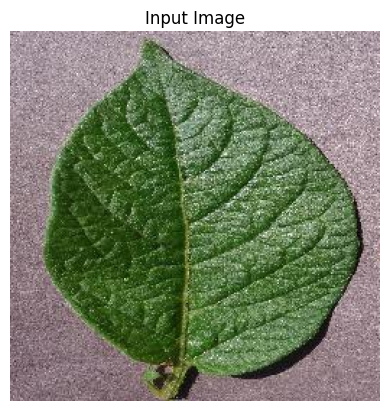

Predicted Disease: Potato___healthy


In [ ]:
image_path=r"/content/dataset/PlantVillage/Potato___healthy/2e0b8b4b-e900-408b-b760-730690bbd382___RS_HL 1901.JPG"
print("Running prediction for example image:")
predict_disease(image_path)

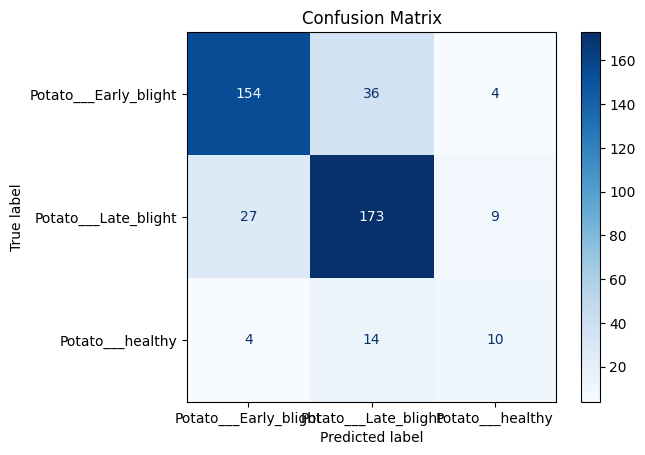

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(svm, X_test, y_test, display_labels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


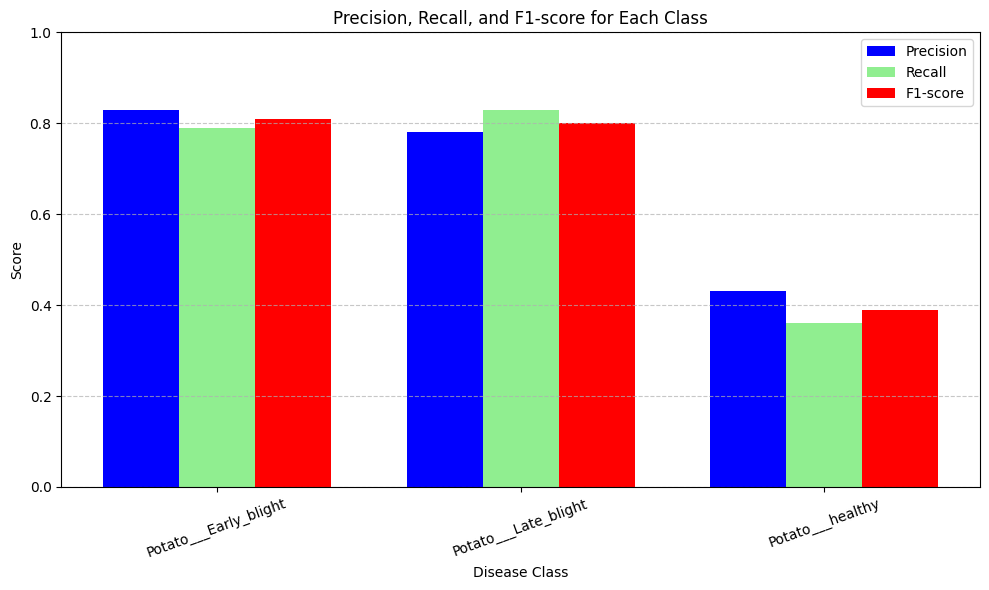

In [ ]:
import matplotlib.pyplot as plt

# Data from classification report
classes = ["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"]
precision = [0.83, 0.78, 0.43]
recall = [0.79, 0.83, 0.36]
f1_score = [0.81, 0.80, 0.39]

x = np.arange(len(classes))  # Class positions
width = 0.25  # Width of bars

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision', color='blue')
plt.bar(x, recall, width, label='Recall', color='lightgreen')
plt.bar(x + width, f1_score, width, label='F1-score', color='red')

plt.xlabel('Disease Class')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score for Each Class')
plt.xticks(x, classes, rotation=20)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


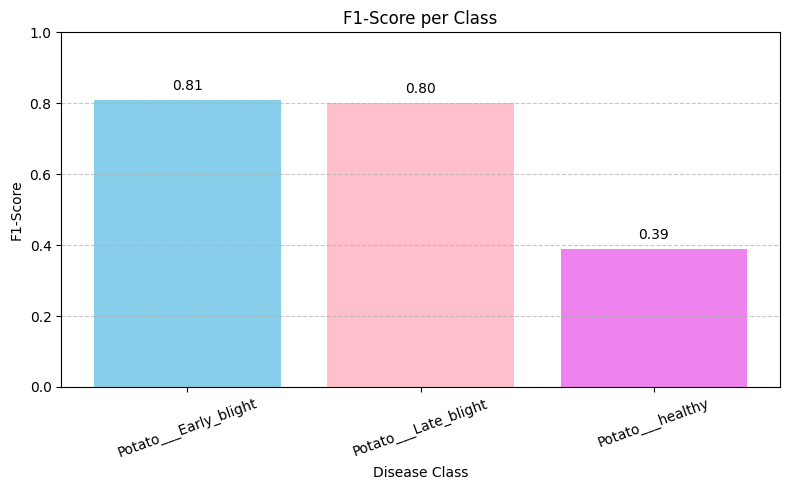

In [ ]:

# Class labels and their corresponding F1-scores
classes = ["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"]
f1_scores = [0.81, 0.80, 0.39]  # These come from your classification report

# Plotting the F1-score per class
plt.figure(figsize=(8, 5))
bars = plt.bar(classes, f1_scores, color=['skyblue', 'pink', 'violet'])

# Add score labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

plt.title('F1-Score per Class')
plt.xlabel('Disease Class')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


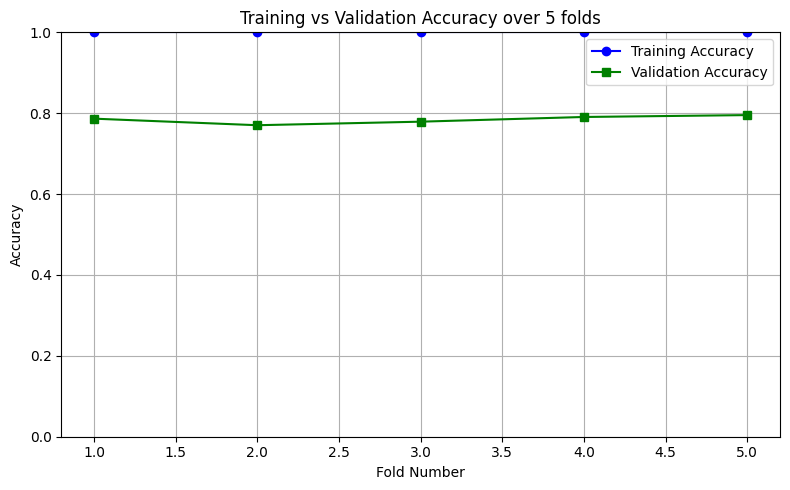

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Prepare cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_accuracies = []
val_accuracies = []

for train_index, val_index in kf.split(X, y):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    model = SVC(kernel='linear')
    model.fit(X_train_fold, y_train_fold)

    train_acc = model.score(X_train_fold, y_train_fold)
    val_acc = model.score(X_val_fold, y_val_fold)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Plot training vs validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), train_accuracies, marker='o', label='Training Accuracy', color='blue')
plt.plot(range(1, 6), val_accuracies, marker='s', label='Validation Accuracy', color='green')
plt.title("Training vs Validation Accuracy over 5 folds")
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


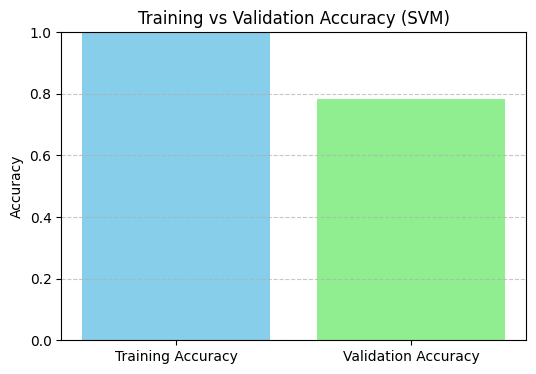

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Train the model
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Predict and calculate accuracy
train_accuracy = svm.score(X_train, y_train)
val_accuracy = svm.score(X_test, y_test)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(['Training Accuracy', 'Validation Accuracy'], [train_accuracy, val_accuracy], color=['skyblue', 'lightgreen'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy (SVM)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


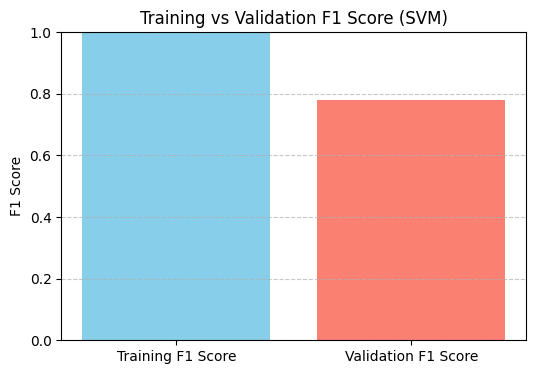

In [ ]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Predict on training and test sets
y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)

# Compute F1 scores
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
val_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Plot
plt.figure(figsize=(6, 4))
plt.bar(['Training F1 Score', 'Validation F1 Score'], [train_f1, val_f1], color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.ylabel("F1 Score")
plt.title("Training vs Validation F1 Score (SVM)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


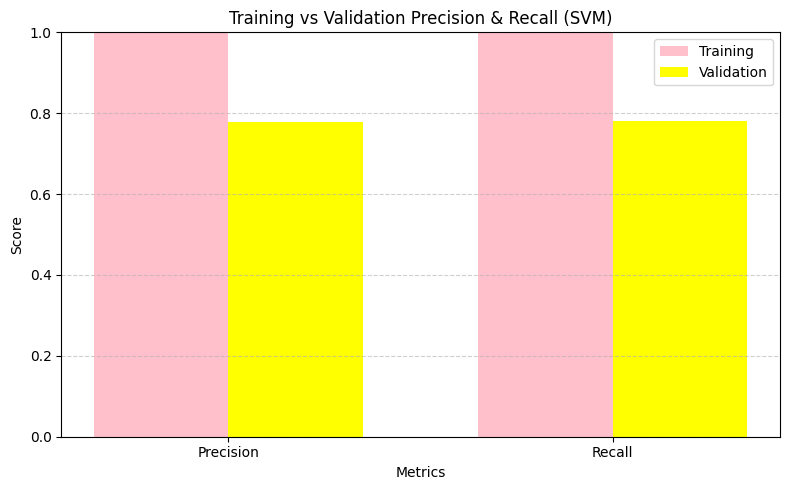

In [ ]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

# Predictions
y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)

# Compute Precision and Recall
train_precision = precision_score(y_train, y_train_pred, average='weighted')
val_precision = precision_score(y_test, y_test_pred, average='weighted')

train_recall = recall_score(y_train, y_train_pred, average='weighted')
val_recall = recall_score(y_test, y_test_pred, average='weighted')

# Plot
labels = ['Precision', 'Recall']
train_scores = [train_precision, train_recall]
val_scores = [val_precision, val_recall]

x = range(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, train_scores, width=width, label='Training', color='pink')
plt.bar([p + width for p in x], val_scores, width=width, label='Validation', color='yellow')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Training vs Validation Precision & Recall (SVM)')
plt.xticks([p + width / 2 for p in x], labels)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!git clone https://github.com/anjum166/Potato_Disease_Prediction(SVM).git
%cd Potato_Disease_Prediction(SVM)


/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `git clone https://github.com/anjum166/Potato_Disease_Prediction(SVM).git'
[Errno 2] No such file or directory: 'Potato_Disease_Prediction(SVM)'
/content
